In [1]:
%matplotlib inline
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

In [2]:
IMAGE_DIR = 'training data set'
DEFAULT_SIZE = [250,250] 
def read_images(image_path=IMAGE_DIR, default_size=DEFAULT_SIZE):
    images = []
    images_names = []
    image_dirs = [image for image in os.listdir(image_path) if not image.startswith('.')] 
    for image_dir in image_dirs:
        dir_path = os.path.join(image_path, image_dir) 
        image_names = [image for image in os.listdir(dir_path) if not image.startswith('.')] 
        for image_name in image_names:
            image = Image.open (os.path.join(dir_path, image_name)) 
            image = image.convert ("L") 
            if (default_size is not None ):
                image = image.resize (default_size , Image.ANTIALIAS ) 
            images.append(np.asarray (image , dtype =np. uint8 ))
            images_names.append(image_dir) 
    return [images,images_names]
[a,b]=read_images()

In [3]:
def as_row_matrix (X):
    if len (X) == 0:
        return np. array ([])
    mat = np. empty ((0 , X [0].size ), dtype =X [0]. dtype )
    for row in X:
        mat = np.vstack(( mat , np.asarray( row ).reshape(1 , -1))) # 1 x r*c 
    return mat

In [4]:
def get_number_of_components_to_preserve_variance(eigenvalues, variance=.95):
    for ii, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
        if eigen_value_cumsum > variance:
            return ii

In [5]:
def pca (X, y, num_components =0): 
    [n,d] = X.shape
    if ( num_components <= 0) or ( num_components >n):
        num_components = n
        mu = X.mean( axis =0)
        X = X - mu
    if n>d:
        C = np.dot(X.T,X)
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
    else :
        C = np.dot (X,X.T) 
        [ eigenvalues , eigenvectors ] = np.linalg.eigh(C)
        eigenvectors = np.dot(X.T, eigenvectors )
        for i in range (n):
            eigenvectors [:,i] = eigenvectors [:,i]/ np.linalg.norm( eigenvectors [:,i])
    idx = np.argsort (- eigenvalues )
    eigenvalues = eigenvalues [idx ]
    eigenvectors = eigenvectors [:, idx ]
    num_components = get_number_of_components_to_preserve_variance(eigenvalues)
    eigenvalues = eigenvalues [0: num_components ].copy ()
    eigenvectors = eigenvectors [: ,0: num_components ].copy ()
    return [ eigenvalues , eigenvectors , mu]

In [6]:
def project (W , X , mu):
    return np.dot (X - mu , W)
def reconstruct (W , Y , mu) :
    return np.dot (Y , W.T) + mu

In [7]:
def subplot ( title , images , rows , cols , sptitle ="", sptitles =[] , colormap = plt.cm.gray, filename = None, figsize = (10, 10) ):
    fig = plt.figure(figsize = figsize)
    # main title
    fig.text (.5 , .95 , title , horizontalalignment ="center")
    for i in range ( len ( images )):
        ax0 = fig.add_subplot( rows , cols ,( i +1))
        plt.setp ( ax0.get_xticklabels() , visible = False )
        plt.setp ( ax0.get_yticklabels() , visible = False )
        if len ( sptitles ) == len ( images ):
            plt.title("%s #%s" % ( sptitle , str ( sptitles [i ]) )  )
        else:
            plt.title("%s #%d" % ( sptitle , (i +1) )  )
        plt.imshow(np.asarray(images[i]) , cmap = colormap )
    if filename is None :
        plt.show()
    else:
        fig.savefig( filename )

ValueError: num must be 1 <= num <= 16, not 17

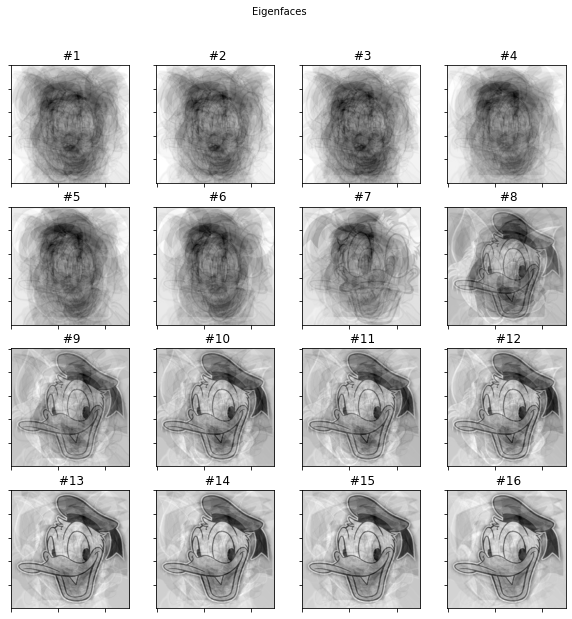

In [28]:
[X, y] = read_images() 
[eigenvalues, eigenvectors, mean] = pca (as_row_matrix(X), y)

steps =[i for i in range (eigenvectors.shape[1])]
E = []
for i in range (len(steps)):
    numEvs = steps[i]
    P = project(eigenvectors[: ,0: numEvs ], X[4].reshape (1 , -1) , mean)
    R = reconstruct(eigenvectors[: ,0: numEvs ], P, mean)
    # reshape and append to plots
    R = R.reshape(X[4].shape ) #1*62500 -> 250*250
    E.append(np.asarray(R))

subplot ( title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="python_pca_eigenfaces.png")

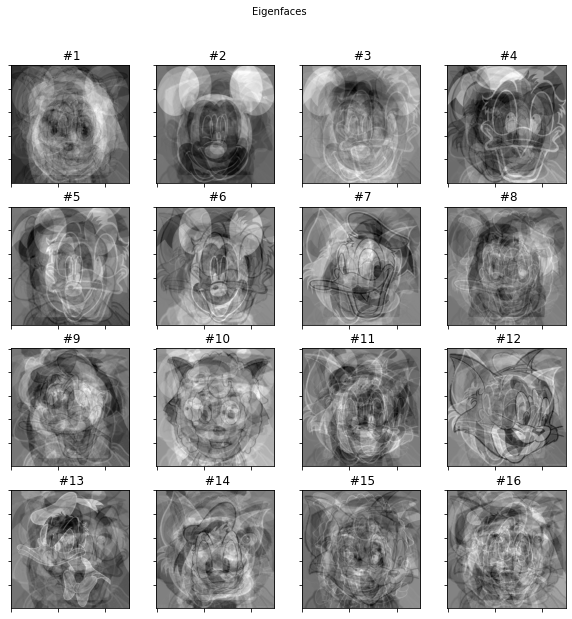

In [25]:
E = []
number = eigenvectors.shape[1]
for i in range (min(number, 16)):
    e = eigenvectors[:,i].reshape(X[0].shape )
    E.append(np.asarray(e))
# plot them and store the plot to " python_eigenfaces .pdf"
subplot ( title ="Eigenfaces", images=E, rows =4, cols =4, colormap =plt.cm.gray , filename ="python_pca_eigenfaces.png")

E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 31456 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 40060 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 21733 missing from current font.
  font.set_text(s, 0.0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 31456 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 40060 missing from current font.
  font.set_text(s, 0, flags=flags)
E:\anaconda\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 21733 missing from current font.
  font.set_text(s, 0, flags=flags)


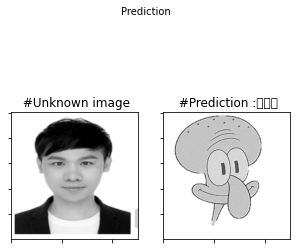

In [19]:
def dist_metric(p,q):
    p = np.asarray(p).flatten()
    q = np.asarray(q).flatten()
    return np.sqrt (np.sum (np. power ((p-q) ,2)))

def predict (W, mu , projections, y, X):
    minDist = float("inf")
    minClass = -1
    Q = project (W, X.reshape (1 , -1) , mu)
    for i in range (len(projections)):
        dist = dist_metric( projections[i], Q)
        if dist < minDist:
            minDist = dist
            minClass = i
    return minClass

projections = []
for xi in X:
    projections.append(project (eigenvectors, xi.reshape(1 , -1) , mean))

image = Image.open("yang.png")
image = image.convert ("L")
if (DEFAULT_SIZE is not None ):
    image = image.resize (DEFAULT_SIZE , Image.ANTIALIAS )
test_image = np. asarray (image , dtype =np. uint8 )
predicted = predict(eigenvectors, mean , projections, y, test_image)

subplot ( title ="Prediction", images =[test_image, X[predicted]], rows =1, cols =2, 
         sptitles = ["Unknown image", "Prediction :{0}".format(y[predicted])] , colormap =plt.cm.gray , 
         filename ="prediction_test.png", figsize = (5,5))